In [1]:
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.stem import WordNetLemmatizer
import json
import pickle

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random
from keras.models import load_model

In [2]:
# create an object of WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# importing the GL Bot corpus file for pre-processing
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open("pertanian_paketingan.json").read()
intents = json.loads(data_file)

In [3]:
# preprocessing the json data
# tokenization
#nltk.download('punkt')
#nltk.download('wordnet')
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [4]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

# sort classes
classes = sorted(list(set(classes)))

# documents = combination between patterns and intents
print (len(documents), "documents")

# classes = intents
print (len(classes), "classes", classes)

# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)

# creating a pickle file to store the Python objects which we will use while predicting
pickle.dump(words,open('texts.pkl','wb')) 
pickle.dump(classes,open('labels.pkl','wb'))

61 documents
29 classes ['TaniBot', 'berapa_kali_panen', 'ciri_hama_tikus', 'ciri_hama_wereng', 'goodbye', 'greeting', 'harga_padi', 'jenis_bibit', 'jenis_pupuk', 'jenis_tanah', 'kendala_petani', 'lama_panen', 'lama_panen_dari_hamil', 'memantau_padi', 'mengolah_padi_beras', 'pembajakan_sawah', 'pemisahan_padi', 'penanggulangan_hama', 'penanggulangan_hama_tikus', 'penanggulangan_hama_wereng', 'penyebab_gagal_panen', 'perairan_sawah', 'perawatan_sawah', 'persentasi_hasil_panen', 'proses_menanam_padi', 'sistem_pertanian_paketingan', 'sumber_perairan_sawah', 'target_pasar', 'terimakasih']
105 unique lemmatized words ['1', 'afternoon', 'agar', 'alami', 'apa', 'bagaimana', 'bai', 'banyak', 'berapa', 'beras', 'bibit', 'bisa', 'bro', 'bye', 'byee', 'cara', 'ciri-ciri', 'dadah', 'dah', 'dalam', 'dari', 'desa', 'di', 'digunakan', 'ditanam', 'gagal', 'good', 'hai', 'hallo', 'halo', 'hama', 'hamil', 'harga', 'hasil', 'hei', 'hi', 'hy', 'itu', 'jenis', 'jual', 'jumpa', 'kali', 'kasih', 'kawan', 'ke

In [5]:
# create our training data
training = []

# create an empty array for our output
output_empty = [0] * len(classes)

# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
   
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

# shuffle features and converting it into numpy arrays
random.shuffle(training)
training = np.array(training)

# create train and test lists
train_x = list(training[:,0])
train_y = list(training[:,1])

print("Training data created")

Training data created


In [6]:
training.shape

(61, 2)

In [7]:
len(train_x)

61

In [8]:
len(train_y)

61

In [9]:
# Create NN model to predict the responses
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               13568     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 29)                1885      
                                                                 
Total params: 23,709
Trainable params: 23,709
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [12]:
# train model
history = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)

Epoch 1/200
13/13 [==============================] - 12s 21ms/step - loss: 3.3627 - accuracy: 0.0164
Epoch 2/200
13/13 [==============================] - 0s 7ms/step - loss: 3.2714 - accuracy: 0.1967
Epoch 3/200
13/13 [==============================] - 0s 8ms/step - loss: 3.1054 - accuracy: 0.3279
Epoch 4/200
13/13 [==============================] - 0s 8ms/step - loss: 2.9475 - accuracy: 0.2623
Epoch 5/200
13/13 [==============================] - 0s 9ms/step - loss: 2.8112 - accuracy: 0.2459
Epoch 6/200
13/13 [==============================] - 0s 9ms/step - loss: 2.7049 - accuracy: 0.2951
Epoch 7/200
13/13 [==============================] - 0s 10ms/step - loss: 2.6149 - accuracy: 0.3115
Epoch 8/200
13/13 [==============================] - 0s 17ms/step - loss: 2.4188 - accuracy: 0.2951
Epoch 9/200
13/13 [==============================] - 0s 11ms/step - loss: 2.2527 - accuracy: 0.4098
Epoch 10/200
13/13 [==============================] - 0s 19ms/step - loss: 2.0660 - accuracy: 0.3770
Epo

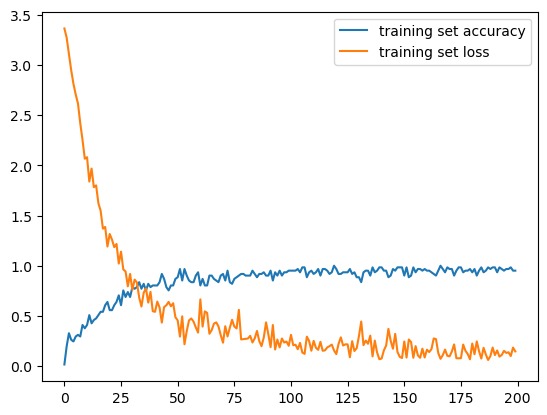

In [13]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'], label='training set accuracy')
plt.plot(history.history['loss'], label='training set loss')
plt.legend()

In [14]:
model.save('models.h5', history)